In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from torch.utils.tensorboard import SummaryWriter

# Sinusoidal Positional Encoding
def get_sinusoidal_encoding(seq_len, embed_dim):
    pe = torch.zeros(seq_len, embed_dim)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

# Improved Multi-task Transformer Encoder 
class MultiTaskNumericEncoder(nn.Module):
    def __init__(self, seq_len, embed_dim=128, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.seq_len = seq_len

        self.value_embedding = nn.Linear(1, embed_dim)

        pos_enc = get_sinusoidal_encoding(seq_len, embed_dim)
        self.register_buffer("pos_enc", pos_enc.unsqueeze(0))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classification_head = nn.Linear(embed_dim, 1)
        self.regression_head = nn.Linear(embed_dim, 1)

    def forward(self, x_hidden):
        x_embed = self.value_embedding(x_hidden.unsqueeze(-1)) + self.pos_enc

        encoder_output = self.transformer_encoder(x_embed)

        class_logits = self.classification_head(encoder_output).squeeze(-1)
        classification_output = torch.sigmoid(class_logits)
        regression_output = self.regression_head(encoder_output).squeeze(-1)

        return classification_output, regression_output


In [2]:
# Training function with metrics logging and checkpointing
def train_model(model, train_loader, val_loader, epochs, lr=1e-4, alpha=0.5, device='cuda'):
    criterion_class = nn.BCELoss()
    criterion_reg = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
    model.to(device)

    writer = SummaryWriter()

    best_metrics = {}
    steps_per_epoch = len(train_loader)
    eval_interval = max(1, steps_per_epoch // 10)
    i=0

    for epoch in range(epochs):
        model.train()
        for step, batch in enumerate(train_loader):
            x_filled = batch['x_hidden'].to(device)
            nan_mask = batch['nan_mask'].to(device)
            training_mask = batch['training_mask'].to(device)
            x_original = batch['x_original'].to(device)
            classification_output, regression_output = model(x_filled)

            class_loss = criterion_class(classification_output, nan_mask)
            reg_loss = criterion_reg(regression_output*training_mask, x_original*training_mask)

            total_loss = alpha * class_loss + (1 - alpha) * reg_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if step % eval_interval == 0 or step == steps_per_epoch - 1:
                print(f"Eval Number: {i}")
                i+=1
                model.eval()
                for phase, loader in [('Train', train_loader), ('Validation', val_loader)]:
                    all_nan_masks, all_train_masks = [], []
                    all_targets, all_preds_class, all_preds_reg = [], [], []

                    with torch.no_grad():
                        for batch in loader:
                            x_filled = batch['x_hidden'].to(device)
                            nan_mask = batch['nan_mask'].to(device)
                            training_mask = batch['training_mask'].to(device)
                            x_original = batch['x_original'].to(device)
                            val_class_out, val_reg_out = model(x_filled)

                            all_nan_masks.extend(nan_mask.cpu().numpy().flatten())
                            all_train_masks.extend(training_mask.cpu().numpy().flatten())
                            all_targets.extend(x_original.cpu().numpy().flatten())
                            all_preds_class.extend(val_class_out.cpu().numpy().flatten())
                            all_preds_reg.extend(val_reg_out.cpu().numpy().flatten())

                    # Classification metrics: Evaluate original missingness prediction (nan_mask)
                    class_mask_indices = np.array(all_nan_masks) >= 0  # Evaluate classification everywhere
                    bin_preds = (np.array(all_preds_class)[class_mask_indices] > 0.5).astype(int)
                    bin_targets = np.array(all_nan_masks)[class_mask_indices]

                    # Regression metrics: Evaluate only on hidden-for-training positions (training_mask)
                    reg_mask_indices = np.array(all_train_masks) == 1
                    reg_preds = np.array(all_preds_reg)[reg_mask_indices]
                    reg_targets = np.array(all_targets)[reg_mask_indices]

                    metrics = {}

                    # Classification metrics (Sometimes no missing classes)
                    if len(np.unique(bin_targets)) > 1:
                        metrics.update({
                            'F1': f1_score(bin_targets, bin_preds),
                            'Precision': precision_score(bin_targets, bin_preds),
                            'Recall': recall_score(bin_targets, bin_preds),
                            'ROC-AUC': roc_auc_score(bin_targets, np.array(all_preds_class)[class_mask_indices])
                        })

                    # Regression metrics (veryy slim possibiliy empty)
                    if reg_targets.size > 0:
                        metrics.update({
                            'MSE': mean_squared_error(reg_targets, reg_preds),
                            'MAE': mean_absolute_error(reg_targets, reg_preds),
                            'R2': r2_score(reg_targets, reg_preds)
                        })

                    # Log metrics safely
                    for metric_name, metric_value in metrics.items():
                        writer.add_scalar(f'{phase}/{metric_name}', metric_value, epoch * steps_per_epoch + step)
                        if phase == 'Validation':
                            if metric_name not in best_metrics or \
                                (metric_name in ['MSE', 'MAE'] and metric_value < best_metrics[metric_name]) or \
                                (metric_name not in ['MSE', 'MAE'] and metric_value > best_metrics[metric_name]):
                                best_metrics[metric_name] = metric_value
                                checkpoint = {
                                    'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                }
                                torch.save(checkpoint, f'D:\\Mouse\\Notebooks\\Models\\checkpoint_best_{metric_name}_{metric_value}.pt')
                    
                model.train()

        scheduler.step()

    writer.close()

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np

samples = np.load('samples43Regions.npy')

class MaskedNumericDataset(Dataset):
    def __init__(self, data_original, data_hidden, nan_mask_tensor, training_mask_tensor):
        self.data_original = data_original
        self.data_hidden = data_hidden
        self.nan_mask = nan_mask_tensor
        self.training_mask = training_mask_tensor

    def __len__(self):
        return self.data_original.shape[0]

    def __getitem__(self, idx):
        return {
            'x_original': self.data_original[idx],
            'x_hidden': self.data_hidden[idx],
            'nan_mask': self.nan_mask[idx],
            'training_mask': self.training_mask[idx]
        }


# Prepare data function ensuring at least 1 hidden position
def prepare_data(data, hidden_fraction=0.15):
    # Create a mask indicating which positions were originally NaN
    nan_mask = np.isnan(data).astype(np.float32)
    # Initialize a hidden mask (all zeros) with the same shape as the data
    hidden_mask = np.zeros_like(data, dtype=np.float32)
    
    # Determine the total number of features per sample
    num_features = data.shape[1]
    num_hidden = int(num_features * hidden_fraction)
    
    for i in range(len(data)):
        # Use all indices (both NaNs and values)
        all_indices = np.arange(num_features)
        
        # Randomly select indices from all available indices
        hidden_indices = np.random.choice(all_indices, size=num_hidden, replace=False)
        hidden_mask[i, hidden_indices] = 1
    
    # Replace NaN values with 0.0
    data_original = np.nan_to_num(data, nan=0.0)

    # set hidden positions to 0.0 with 10% time random value and 10% time unchanged
    data_hidden = data_original.copy()

    # Get all hidden positions
    current_vals = data_hidden[hidden_mask == 1]  # shape: (total_hidden_positions,)

    # Generate random numbers for each hidden element
    r = np.random.rand(current_vals.size)  # one random value per hidden position
    rand_vals = np.random.uniform(0.0, 12.0, size=current_vals.size)

    # Apply the rules:
    # - if r < 0.1: use a random value
    # - if 0.1 <= r < 0.2: leave unchanged (keep current_vals)
    # - if r >= 0.2: set to 0.0
    new_vals = np.where(r < 0.1, rand_vals, 
                        np.where(r >= 0.2, -1.0, current_vals))

    # Update the data_hidden array at the hidden positions
    data_hidden[hidden_mask == 1] = new_vals

    data_original = torch.tensor(data_original, dtype=torch.float32)
    data_hidden = torch.tensor(data_hidden, dtype=torch.float32)
    nan_mask_tensor = torch.tensor(nan_mask, dtype=torch.float32)
    training_mask_tensor = torch.tensor(hidden_mask, dtype=torch.float32)

    return data_original, data_hidden, nan_mask_tensor, training_mask_tensor


# Load the flattened data (shape: (8460*104, 43))
samples = np.load('samples43Regions.npy')

# Define original dimensions
numSamples = 8460    # total number of samples
numCellTypes = 104   # number of cell types (rows) per sample

# Create sample labels: each sample index is repeated for its corresponding 104 rows.
sample_labels = np.repeat(np.arange(numSamples), numCellTypes)

# Create an array of unique sample indices
sample_indices = np.arange(numSamples)

# Split sample indices into training and test sets (e.g., 80% train, 20% test)
# Check BERTs
train_samples, test_samples = train_test_split(sample_indices, test_size=0.2, random_state=42)

# Create boolean masks to select rows for each split based on sample_labels
train_mask = np.isin(sample_labels, train_samples)
test_mask = np.isin(sample_labels, test_samples)

# Use the masks to filter the flattened data
train_data = samples[train_mask]
test_data = samples[test_mask]

np.random.seed(42)
np.random.shuffle(train_data)
np.random.shuffle(test_data)


train_dataset = MaskedNumericDataset(*prepare_data(train_data))
test_dataset = MaskedNumericDataset(*prepare_data(test_data))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

input_dim = samples.shape[1]  # which is 43
model = MultiTaskNumericEncoder(input_dim, embed_dim=256, num_heads=4, num_layers=6, dropout=0.1)

train_model(model, train_loader, test_loader, epochs=11, lr=1e-4, alpha=0.5)


Eval Number: 0
Eval Number: 1
Eval Number: 2
Eval Number: 3
Eval Number: 4
Eval Number: 5
Eval Number: 6
Eval Number: 7
Eval Number: 8
Eval Number: 9
Eval Number: 10
Eval Number: 11
Eval Number: 12
Eval Number: 13
Eval Number: 14
Eval Number: 15
Eval Number: 16
Eval Number: 17
Eval Number: 18
Eval Number: 19
Eval Number: 20
Eval Number: 21
Eval Number: 22
Eval Number: 23
Eval Number: 24
Eval Number: 25
Eval Number: 26
Eval Number: 27
Eval Number: 28
Eval Number: 29
Eval Number: 30
Eval Number: 31
Eval Number: 32
Eval Number: 33
Eval Number: 34
Eval Number: 35
Eval Number: 36
Eval Number: 37
Eval Number: 38
Eval Number: 39
Eval Number: 40
Eval Number: 41
Eval Number: 42
Eval Number: 43
Eval Number: 44
Eval Number: 45
Eval Number: 46
Eval Number: 47
Eval Number: 48
Eval Number: 49
Eval Number: 50
Eval Number: 51
Eval Number: 52
Eval Number: 53
Eval Number: 54
Eval Number: 55
Eval Number: 56
Eval Number: 57
Eval Number: 58
Eval Number: 59
Eval Number: 60
Eval Number: 61
Eval Number: 62
Ev

KeyboardInterrupt: 

In [ ]:
# Get the first batch from the DataLoader
batch = next(iter(train_loader))
print("Original Input values:\n", batch['x_original'].detach().cpu().numpy())
print("Hidden Input values:\n", batch['x_hidden'].detach().cpu().numpy())
print("NaN Mask values:\n", batch['nan_mask'].detach().cpu().numpy())
print("Training Mask values:\n", batch['training_mask'].detach().cpu().numpy())

Original Input values:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         5.0628905  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.01129913 ... 0.         0.         0.        ]]
Hidden Input values:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         5.0628905  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.01129913 ... 0.         0.         0.        ]]
NaN Mask values:
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.

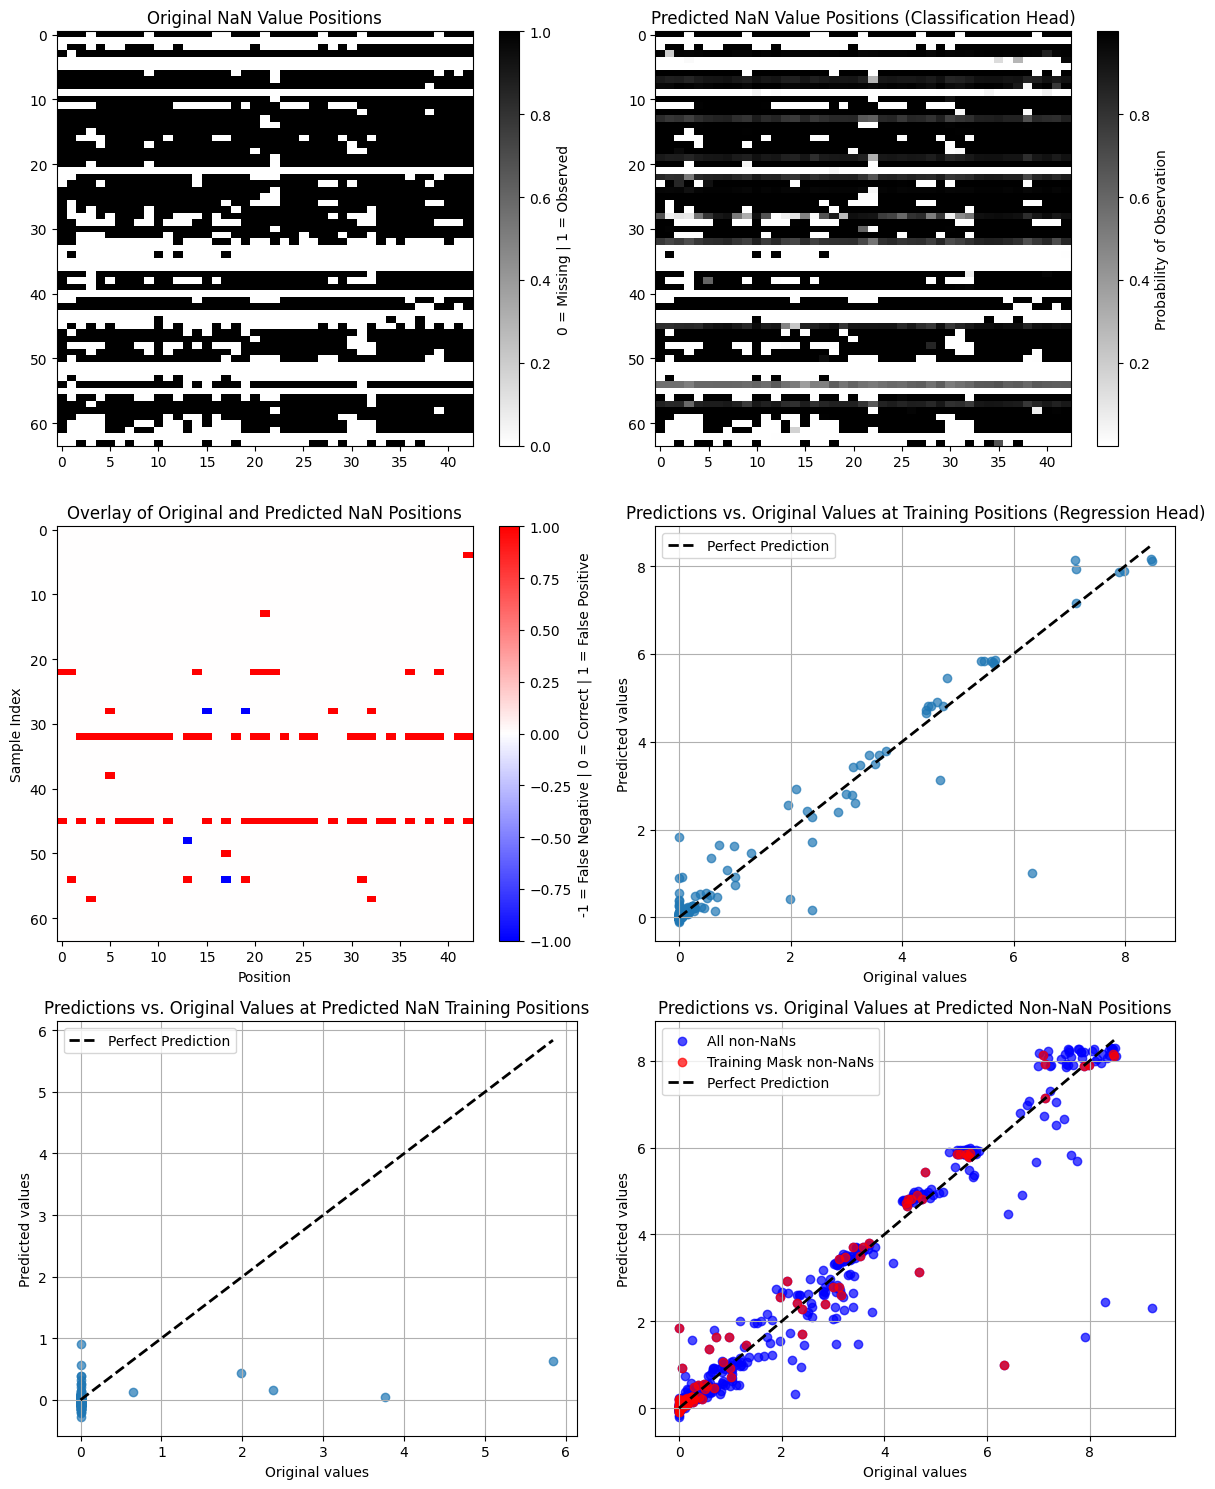

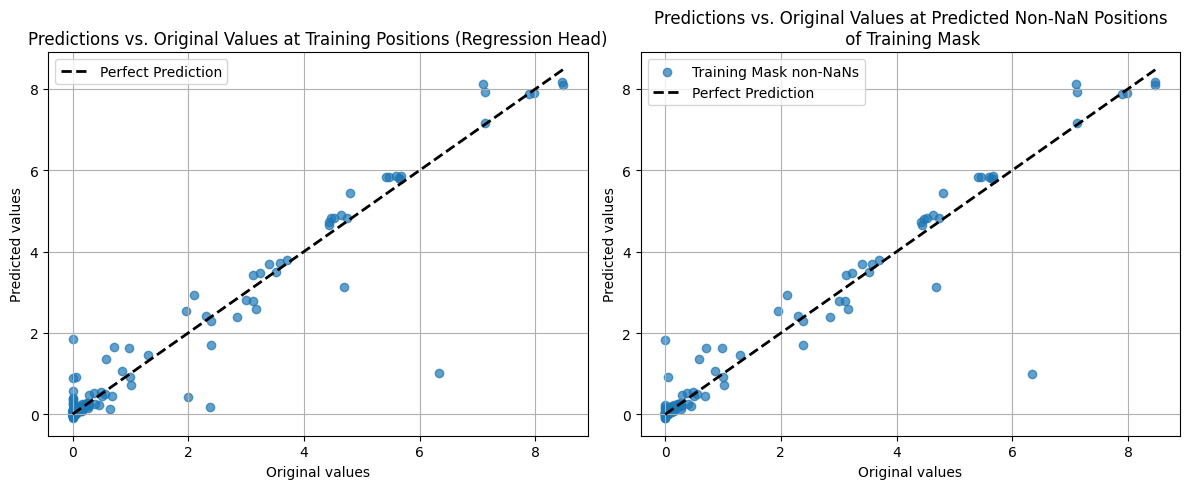

In [5]:
import matplotlib.pyplot as plt

# Load checkpoint
checkpoint_path = r"D:\Mouse\Notebooks\Models\checkpoint_best_MSE_0.17921748757362366.pt"
checkpoint = torch.load(checkpoint_path, map_location='cpu')

# Ensure model structure is defined before loading checkpoint
model = MultiTaskNumericEncoder(input_dim, embed_dim=256, num_heads=4, num_layers=6, dropout=0.1)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Get one batch from test loader
batch = next(iter(test_loader))

with torch.no_grad():
    classification_pred, regression_pred = model(batch['x_hidden'])

# Extract positions hidden for training
training_positions = batch['training_mask'].bool().cpu().numpy()

# Classification
original_NaN_mask = batch['nan_mask'].cpu().numpy()
classification_pred = classification_pred.detach().cpu().numpy()
pred_binary = (classification_pred > 0.5).astype(int) # Threshold 0.5
difference_map = pred_binary - original_NaN_mask

# Regression
original_value = batch['x_original'].cpu().numpy()[training_positions]
regression_pred_value = regression_pred.detach().cpu().numpy()[training_positions]
# Extract positions where the model predicted "observed" (classification_pred > 0.5)
pred_observed_positions = classification_pred < 0.5
# Filter original values and regression predictions
filtered_original_value = batch['x_original'].cpu().numpy()[pred_observed_positions]
filtered_regression_pred = regression_pred.detach().cpu().numpy()[pred_observed_positions]
# Identify points in both filtered_original_value and original_value
filtered_common_values = np.isin(filtered_original_value, original_value)
# For Predicted NaNs
NaN_filtered_original_value = batch['x_original'].cpu().numpy()[~pred_observed_positions]
NaN_filtered_regression_pred = regression_pred.detach().cpu().numpy()[~pred_observed_positions]


# Plot both heatmaps side by side
plt.figure(figsize=(12, 15))

plt.subplot(3, 2, 1)
plt.imshow(original_NaN_mask, cmap='gray_r', aspect='auto')
plt.title('Original NaN Value Positions')
plt.colorbar(label='0 = Missing | 1 = Observed')

plt.subplot(3, 2, 2)
plt.imshow(classification_pred, cmap='gray_r', aspect='auto')
plt.title('Predicted NaN Value Positions (Classification Head)')
plt.colorbar(label='Probability of Observation')

plt.subplot(3, 2, 3)
plt.imshow(difference_map, cmap='bwr', aspect='auto')  # 'bwr' = blue (FN) / red (FP)
plt.colorbar(label='-1 = False Negative | 0 = Correct | 1 = False Positive')
plt.title('Overlay of Original and Predicted NaN Positions')
plt.xlabel('Position')
plt.ylabel('Sample Index')
plt.grid(False)

plt.subplot(3, 2, 4)
plt.scatter(original_value, regression_pred_value, alpha=0.7)
plt.plot([min(original_value), max(original_value)], [min(original_value), max(original_value)], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Original values')
plt.ylabel('Predicted values')
plt.title('Predictions vs. Original Values at Training Positions (Regression Head)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 5)
plt.scatter(NaN_filtered_original_value, NaN_filtered_regression_pred, alpha=0.7)
plt.plot([min(NaN_filtered_original_value), max(NaN_filtered_original_value)], [min(NaN_filtered_original_value), max(NaN_filtered_original_value)], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Original values')
plt.ylabel('Predicted values')
plt.title('Predictions vs. Original Values at Predicted NaN Training Positions')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 6)
plt.scatter(filtered_original_value, filtered_regression_pred, 
            color='blue', alpha=0.7, label='All non-NaNs')
plt.scatter(filtered_original_value[filtered_common_values], filtered_regression_pred[filtered_common_values], 
            color='red', alpha=0.7, label='Training Mask non-NaNs')
plt.plot([min(original_value), max(original_value)], 
         [min(original_value), max(original_value)], 
         'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Original values')
plt.ylabel('Predicted values')
plt.title('Predictions vs. Original Values at Predicted Non-NaN Positions')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(original_value, regression_pred_value, alpha=0.7)
plt.plot([min(original_value), max(original_value)], [min(original_value), max(original_value)], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Original values')
plt.ylabel('Predicted values')
plt.title('Predictions vs. Original Values at Training Positions (Regression Head)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(filtered_original_value[filtered_common_values], filtered_regression_pred[filtered_common_values], alpha=0.7, label='Training Mask non-NaNs')
plt.plot([min(original_value), max(original_value)], 
         [min(original_value), max(original_value)], 
         'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Original values')
plt.ylabel('Predicted values')
plt.title('Predictions vs. Original Values at Predicted Non-NaN Positions\n of Training Mask')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Splitting by cell:

In [ ]:
# Number of cell types
n_cell_type = 104

# Total number of cells in the dataset
n_cells = samples.shape[0]
n_genes = n_cells // n_cell_type

# Create a label for each cell representing its cell type
labels = np.tile(np.arange(n_cell_type), n_genes)

# Define the array of unique cell types
cell_types = np.arange(n_cell_type)

# Randomly split the cell types: 80% for training and 20% exclusively for testing.
# This ensures that the test cell types do not appear in the training data.
train_types, test_types = train_test_split(cell_types, test_size=0.2, random_state=42)

# Create masks to select rows whose cell type is in the designated train or test groups
train_idx = np.isin(labels, train_types)
test_idx = np.isin(labels, test_types)

# Filter the samples to obtain training and testing sets
train_data = samples[train_idx]
test_data = samples[test_idx]

# shuffle the training and testing sets
np.random.seed(42)
np.random.shuffle(train_data)
np.random.shuffle(test_data)

# Reminder of how the booleen indexing happens:


In [ ]:
import numpy as np

# Suppose our data_hidden array (1D for simplicity)
data_hidden = np.array([0.3, 0.2, 0.7, 0.4, 0.9, 0.5])

# And our boolean mask indicating which positions to replace:
mask = np.array([True, False, True, False, False, False])

# When we index with the mask, we get the elements corresponding to True:
print("Before:", data_hidden[mask])  # Output: [0.3, 0.7]

# If new_vals is:
new_vals = np.array([0.5, 0.0])

# Then assigning:
data_hidden[mask] = new_vals

print("After:", data_hidden)  # Output: [0.5, 0.2, 0.0, 0.4, 0.9, 0.5]

In [19]:
import numpy as np

# Create an example 2D array (data_hidden) and a corresponding hidden_mask.
data_hidden = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                        [1.1, 1.2, 1.3, 1.4, 1.5, 1.6],
                        [2.1, 2.2, 2.3, 2.4, 2.5, 2.6]])

# Define a hidden_mask with 1's indicating which positions are "hidden".
# For example, here we mark the 1st and 3rd elements of the first row,
# the 2nd and 4th of the second row, and the 5th and 6th of the third row.
hidden_mask = np.array([[1, 0, 1, 0, 0, 0],
                        [0, 1, 0, 1, 0, 0],
                        [0, 0, 0, 0, 1, 1]], dtype=np.int32)

# For demonstration, print the original data and the mask.
print("Original data_hidden:")
print(data_hidden)
print("\nHidden mask (1 indicates hidden positions):")
print(hidden_mask)

# ------------------------------
# Now apply the logic for modifying the hidden positions.
# Step 1: Copy the data to work on it.
data_hidden_modified = data_hidden.copy()

# Step 2: Initially set all positions where hidden_mask is 1 to 0.0.
data_hidden_modified[hidden_mask == 1] = 0.0

# Step 3: Extract the values at hidden positions.
# This will return a 1D array containing the values from each hidden location.
current_vals = data_hidden_modified[hidden_mask == 1]
print("\nCurrent values at hidden positions (after setting to 0.0):")
print(current_vals)
print("Shape of current_vals:", current_vals.shape)

# Step 4: Generate a random number for each hidden element.
# The total number of hidden positions is current_vals.size.
r = np.random.rand(current_vals.size)
# Also generate a random value for each hidden element (from 0.0 to 12.0).
rand_vals = np.random.uniform(0.0, 12.0, size=current_vals.size)

# Step 5: Apply the rules:
# - If r < 0.1, use the corresponding random value from rand_vals.
# - If 0.1 <= r < 0.2, leave the current value unchanged.
# - If r >= 0.2, set to 0.0.
new_vals = np.where(r < 0.1, 
                    rand_vals, 
                    np.where(r >= 0.2, 0.0, current_vals))

# Print the random probabilities, random values, and new_vals for clarity.
print("\nRandom probabilities (r):")
print(r)
print("\nRandom replacement values (rand_vals):")
print(rand_vals)
print("\nNew values for hidden positions (new_vals):")
print(new_vals)
print("Shape of new_vals:", new_vals.shape)

# Step 6: Replace the values in data_hidden_modified at the hidden positions with new_vals.
data_hidden_modified[hidden_mask == 1] = new_vals

print("\nModified data_hidden after applying new_vals:")
print(data_hidden_modified)


Original data_hidden:
[[0.1 0.2 0.3 0.4 0.5 0.6]
 [1.1 1.2 1.3 1.4 1.5 1.6]
 [2.1 2.2 2.3 2.4 2.5 2.6]]

Hidden mask (1 indicates hidden positions):
[[1 0 1 0 0 0]
 [0 1 0 1 0 0]
 [0 0 0 0 1 1]]

Current values at hidden positions (after setting to 0.0):
[0. 0. 0. 0. 0. 0.]
Shape of current_vals: (6,)

Random probabilities (r):
[0.95302869 0.7661632  0.08746769 0.14588843 0.64811709 0.19167304]

Random replacement values (rand_vals):
[ 5.09710959  7.86377133  3.20118843 10.44451229  9.68606433 11.40844044]

New values for hidden positions (new_vals):
[0.         0.         3.20118843 0.         0.         0.        ]
Shape of new_vals: (6,)

Modified data_hidden after applying new_vals:
[[0.         0.2        0.         0.4        0.5        0.6       ]
 [1.1        3.20118843 1.3        0.         1.5        1.6       ]
 [2.1        2.2        2.3        2.4        0.         0.        ]]
